# Development of a predictive model for maintenance in a water pump plant.

Import libraries needed to develop the project.

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.cluster import hierarchy as hc
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import seaborn as sns
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


Using TensorFlow backend.


## Load and check data available.

In [3]:
train_features = pd.read_csv('https://github.com/Starluxe/IBMAdvancedCapstone/raw/master/train_features.csv')
train_labels = pd.read_csv('https://github.com/Starluxe/IBMAdvancedCapstone/raw/master/train_labels.csv')
test_features = pd.read_csv('https://github.com/Starluxe/IBMAdvancedCapstone/raw/master/test_features.csv')
sample_submission = pd.read_csv('https://github.com/Starluxe/IBMAdvancedCapstone/raw/master/sample_submission.csv')


In [4]:
sample_submission['status_group'].unique()

array(['functional'], dtype=object)

In [5]:
print(train_features.shape, train_labels.shape)
print(test_features.shape, sample_submission.shape)

(59400, 40) (59400, 2)
(14358, 40) (14358, 2)


In [6]:
train_features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [7]:
train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [8]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

In [9]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
id              59400 non-null int64
status_group    59400 non-null object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


Mostly of features are categorical

In [10]:
# Check functional status of water points
train_labels['status_group'].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

In [11]:
train_labels.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [12]:
train_labels.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

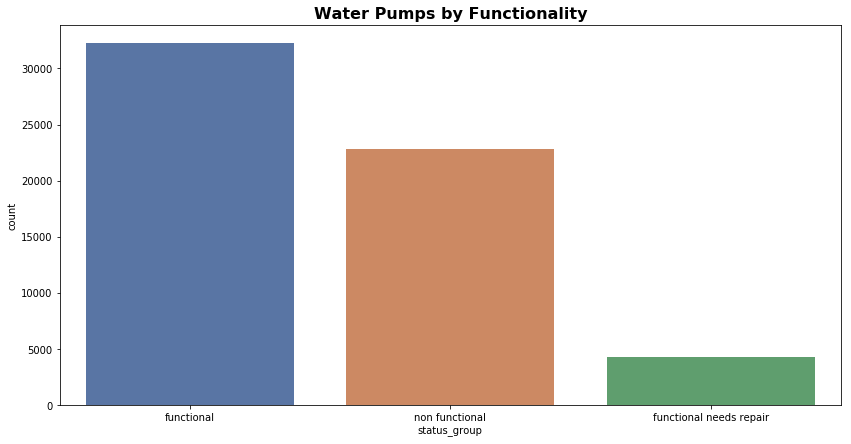

In [13]:
# Graphical representation of pumps status
plt.figure(figsize=(14,7))
plt.title("Water Pumps by Functionality",fontsize=16, fontweight='bold')
sns.countplot(x=train_labels['status_group'], data=train_labels, palette="deep");

We can see some many plants are out of order.

In [14]:
df_pivot = pd.concat([train_features, train_labels], axis=1)
piv_df= df_pivot[['basin','status_group','construction_year']]
piv_table = piv_df.pivot_table(index='basin',
                           columns='status_group', aggfunc='count')
piv_table

construction_year                          \
status_group                   functional functional needs repair   
basin                                                               
Internal                             4482                     557   
Lake Nyasa                           3324                     250   
Lake Rukwa                           1000                     270   
Lake Tanganyika                      3107                     742   
Lake Victoria                        5100                     989   
Pangani                              5372                     477   
Rufiji                               5068                     437   
Ruvuma / Southern Coast              1670                     326   
Wami / Ruvu                          3136                     269   

                                        
status_group            non functional  
basin                                   
Internal                          2746  
Lake Nyasa                        1511  
Lake Rukwa                        1184  
Lake Tanganyika                   2583  
Lake Victoria                     4159  
Pangani                           3091  
Rufiji                            2471  
Ruvuma / Southern Coast           2497  
Wami / Ruvu                       2582

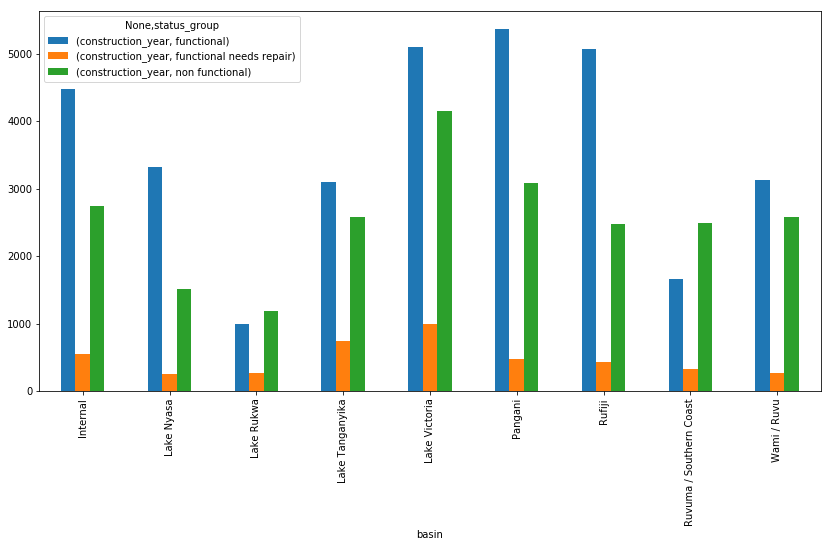

In [15]:
piv_table.plot(kind='bar', figsize=(14,7))

In [16]:
df_pivot = pd.concat([train_features, train_labels], axis=1)
piv_df= df_pivot[['water_quality','status_group','basin']]
piv_table = piv_df.pivot_table(index='water_quality',
                           columns='status_group', aggfunc='count')
piv_table

basin                                       
status_group       functional functional needs repair non functional
water_quality                                                       
coloured                246.0                    54.0          190.0
fluoride                151.0                    13.0           36.0
fluoride abandoned        6.0                     NaN           11.0
milky                   438.0                    14.0          352.0
salty                  2220.0                   225.0         2411.0
salty abandoned         174.0                    72.0           93.0
soft                  28760.0                  3904.0        18154.0
unknown                 264.0                    35.0         1577.0

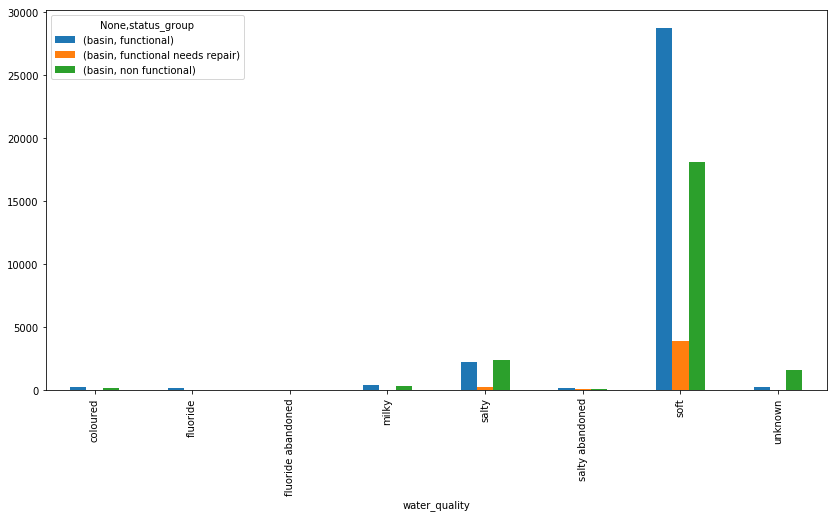

In [17]:
piv_table.plot(kind='bar', figsize=(14,7))

Merge test and train to clean data

In [18]:
X_total = pd.concat([train_features, test_features])
print(X_total.shape)
print(train_features.shape, test_features.shape)

(73758, 40)
(59400, 40) (14358, 40)


In [19]:
X_total.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


Convert date recorded

In [20]:
X_total['date_recorded_months'] = [(pd.to_datetime(date)-pd.to_datetime('2000-01-01')).days/30 for date in X_total['date_recorded']]

In [21]:
X_total['scheme_management_duplicated'] = X_total['scheme_management']

In [22]:
X_total.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,date_recorded_months,scheme_management_duplicated
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,136.333333,VWC
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,160.433333,Other
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,160.133333,VWC
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,159.200000,VWC
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,140.366667,NaN


Replace scheme_management with low frecuency with NaN values to reduce categorical classes. With 250 as the minimum frequency allowed.

In [23]:
X_total = X_total.apply(lambda x: x.mask(x.map(x.value_counts())<250, 'NaN') if x.name=='scheme_management_duplicated' else x)


In [24]:
X_total.scheme_management.value_counts()

VWC                 45600
WUG                  6461
Water authority      3961
WUA                  3537
Water Board          3432
Parastatal           2082
Company              1340
Private operator     1318
Other                 995
SWC                   123
Trust                  92
None                    1
Name: scheme_management, dtype: int64

In [25]:
X_total.scheme_management_duplicated.value_counts()

VWC                 45600
WUG                  6461
Water authority      3961
WUA                  3537
Water Board          3432
Parastatal           2082
Company              1340
Private operator     1318
Other                 995
NaN                   216
Name: scheme_management_duplicated, dtype: int64

Same strategy with other categorical features

In [26]:
X_total = X_total.apply(lambda x: x.mask(x.map(x.value_counts())<250, 'NaN') if x.name=='funder' else x)
X_total = X_total.apply(lambda x: x.mask(x.map(x.value_counts())<250, 'NaN') if x.name=='installer' else x)
X_total = X_total.apply(lambda x: x.mask(x.map(x.value_counts())<250, 'NaN') if x.name=='subvillage' else x)

For numerical values, we create a dummy column for each feature with NaN's for tracking proposal.

In [27]:
X_total['public_meeting_missing'] = X_total['public_meeting'].isna()
X_total['scheme_management_missing'] = X_total['scheme_management'].isna()
X_total['permit_missing'] = X_total['permit'].isna()

Update NaN's with average value. We still keep the NaN's tracking in the new column

In [28]:
X_total['public_meeting'] = X_total['public_meeting'].fillna(X_total['public_meeting'].mode()[0])
X_total['scheme_management'] = X_total['scheme_management'].fillna(X_total['scheme_management'].mode()[0])
X_total['permit'] = X_total['permit'].fillna(X_total['permit'].mode()[0])


There are some misisng values coded diferently in the dataset like the one below

In [29]:
X_total = X_total.replace('none', np.NaN)
X_total = X_total.apply(lambda x: x.mask(x.map(x.value_counts())<100, 'NaN') if x.name=='wpt_name' else x)


There are also NaNs coded as zeros

In [30]:
X_total = X_total.replace('0', np.NaN)
X_total = X_total.apply(lambda x: x.mask(x.map(x.value_counts())<150, 'NaN') if x.name=='ward' else x)
X_total['construction_year_missing'] = (X_total['construction_year'] ==0)*1

In [31]:
#to fill missing dates, we can use: mean, median or the oldest
mean_year = X_total[X_total['construction_year']>0]['construction_year'].mean()
X_total.loc[X_total['construction_year']==0, 'construction_year'] = int(mean_year)

Create a feature column for NaN's tracking

In [32]:
# before filling the null, let's keep track of them
X_total['gps_height_missing'] = X_total['gps_height'].isna()
X_total['num_private_missing'] = X_total['num_private'].isna()
X_total['population_missing'] = X_total['population'].isna()
X_total['amount_tsh_missing'] = X_total['amount_tsh'].isna()

Replace nonsense zeros with mean values

In [33]:
# gps_height
mean_gps_height = X_total[X_total['gps_height']>0]['gps_height'].mean()
X_total.loc[X_total['gps_height']==0, 'gps_height'] = int(mean_gps_height)
# num_private
mean_num_private = X_total[X_total['num_private']>0]['num_private'].mean()
X_total.loc[X_total['num_private']==0, 'num_private'] = int(mean_num_private)
# population
mean_population = X_total[X_total['population']>0]['population'].mean()
X_total.loc[X_total['population']==0, 'population'] = int(mean_population)
# amount_tsh
mean_amount = X_total[X_total['amount_tsh']>0]['amount_tsh'].mean()
X_total.loc[X_total['amount_tsh']==0, 'amount_tsh'] = int(mean_amount)

Remove non relevant columns in our dataset.

In [34]:
X_total_Prep = X_total.drop(columns=['scheme_name','date_recorded','lga','recorded_by', 'waterpoint_type_group', 
                                     'source', 'quality_group','payment_type', 'management_group', 'extraction_type',                                  
                                     'extraction_type_group'],)

In [35]:
X_total_Prep.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,date_recorded_months,scheme_management_duplicated,public_meeting_missing,scheme_management_missing,permit_missing,construction_year_missing,gps_height_missing,num_private_missing,population_missing,amount_tsh_missing
0,69572,6000.0,Roman,1390,NaN,34.938093,-9.856322,NaN,35,Lake Nyasa,...,136.333333,VWC,False,False,False,0,False,False,False,False
1,8776,1064.0,NaN,1399,NaN,34.698766,-2.147466,Zahanati,35,Lake Victoria,...,160.433333,Other,True,False,False,0,False,False,False,False
2,34310,25.0,NaN,686,World vision,37.460664,-3.821329,NaN,35,Pangani,...,160.133333,VWC,False,False,False,0,False,False,False,False
3,67743,1064.0,Unicef,263,UNICEF,38.486161,-11.155298,NaN,35,Ruvuma / Southern Coast,...,159.200000,VWC,False,False,False,0,False,False,False,False
4,19728,1064.0,NaN,1057,NaN,31.130847,-1.825359,Shuleni,35,Lake Victoria,...,140.366667,NaN,False,True,False,1,False,False,False,False


## Hot Encoding the categorical features

In [36]:
X_total_clean = pd.get_dummies(X_total_Prep)
X_total_clean.head()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,public_meeting,...,scheme_management_duplicated_Company,scheme_management_duplicated_NaN,scheme_management_duplicated_Other,scheme_management_duplicated_Parastatal,scheme_management_duplicated_Private operator,scheme_management_duplicated_VWC,scheme_management_duplicated_WUA,scheme_management_duplicated_WUG,scheme_management_duplicated_Water Board,scheme_management_duplicated_Water authority
0,69572,6000.0,1390,34.938093,-9.856322,35,11,5,109,True,...,0,0,0,0,0,1,0,0,0,0
1,8776,1064.0,1399,34.698766,-2.147466,35,20,2,280,True,...,0,0,1,0,0,0,0,0,0,0
2,34310,25.0,686,37.460664,-3.821329,35,21,4,250,True,...,0,0,0,0,0,1,0,0,0,0
3,67743,1064.0,263,38.486161,-11.155298,35,90,63,58,True,...,0,0,0,0,0,1,0,0,0,0
4,19728,1064.0,1057,31.130847,-1.825359,35,18,1,283,True,...,0,0,0,0,0,0,0,0,0,0


In [37]:
X_total_clean.shape

(73758, 277)

## Back to original datasets after cleaning

In [38]:
X_train_clean = X_total_clean[:len(train_features):1]
print(X_train_clean.shape, train_features.shape)

(59400, 277) (59400, 40)


In [39]:
X_test_clean = X_total_clean[len(train_features)::1]
print(X_test_clean.shape, test_features.shape)


(14358, 277) (14358, 40)


At this point we have our datasets ready to  start with our model. But we can check some visualizations of the data

In [40]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
from statsmodels.graphics.mosaicplot import mosaic

In [41]:
df_viz = pd.concat([X_train_clean, train_labels['status_group']], axis=1)
df_viz.shape

(59400, 278)

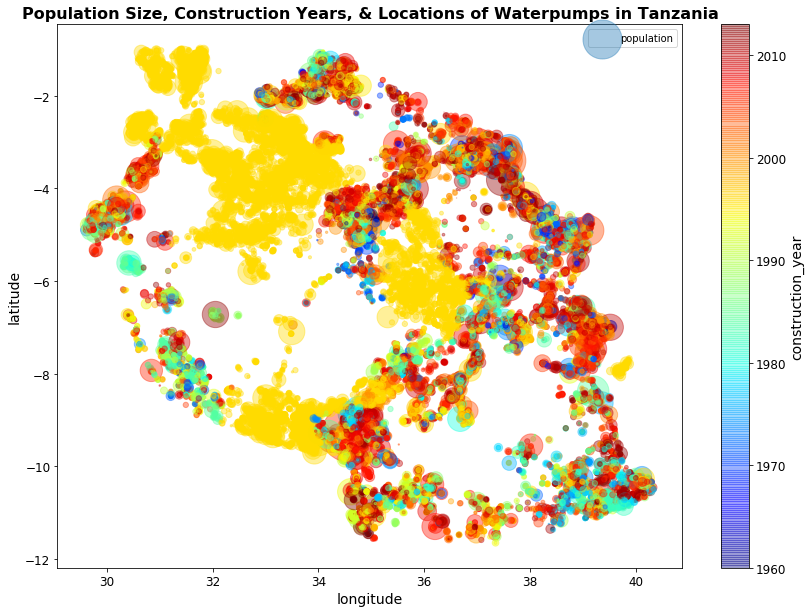

In [42]:
df_viz[df_viz['longitude']>0] [df_viz['latitude']<0][df_viz['construction_year']>0].plot\
  (kind='scatter', x="longitude", y="latitude", alpha=0.4,
s = df_viz["population"]/10, label="population", figsize=(14,10),

c="construction_year", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False);
plt.title("Population Size, Construction Years, & Locations of Waterpumps in Tanzania", 
         fontsize =16, fontweight='bold')
plt.legend;

Text(0.5, 1.0, 'Water Pump Construction by Years')

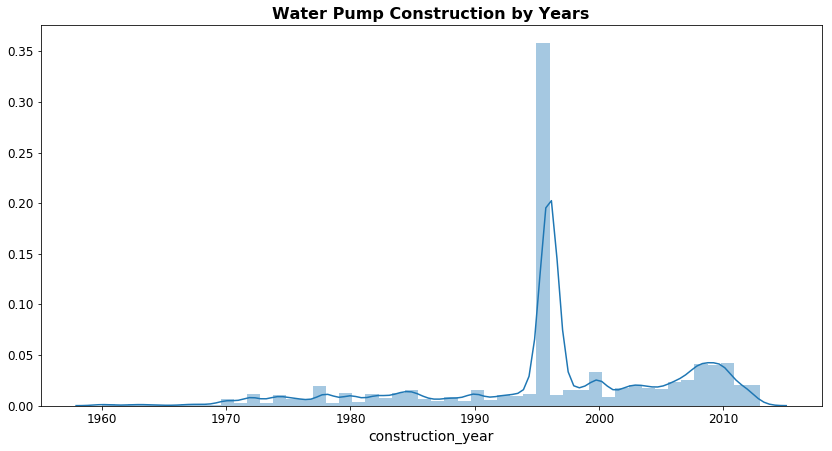

In [43]:
plt.figure(figsize=(14, 7))
sns.distplot(df_viz['construction_year'][df_viz['construction_year']>0]);
plt.title("Water Pump Construction by Years", fontsize=16, fontweight='bold')

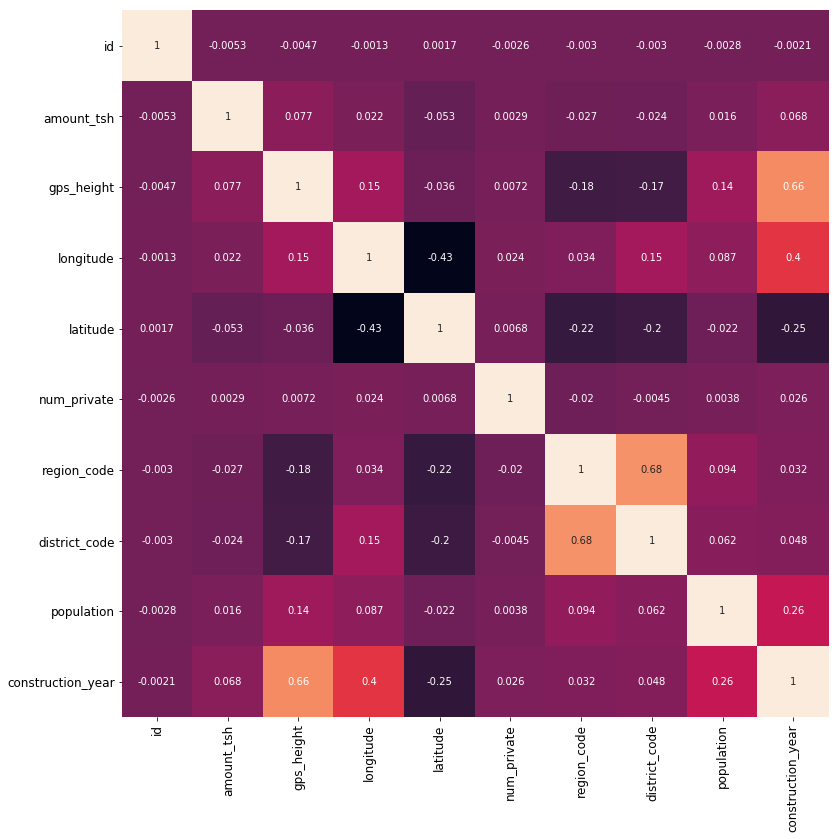

In [44]:
concat_table = pd.concat([train_features, train_labels['status_group']], axis=1)
corr_table = concat_table.corr()
plt.figure(figsize=(14,13))
sns.heatmap(corr_table, square=True, annot=True, cbar=False);

<Figure size 1440x1008 with 0 Axes>

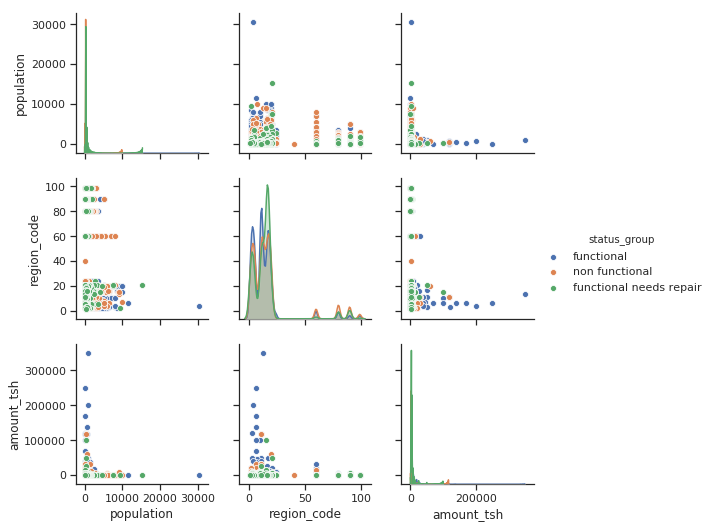

In [45]:
plt.figure(figsize=(20,14))
sns.set(style='ticks')
sns.pairplot(df_viz[['population', 'region_code', 'amount_tsh', 'status_group']],\
            hue='status_group', diag_kind='kde');

amount_tsh : Total static head (amount water available to waterpoint)  
num_private :  
population : Population around the well


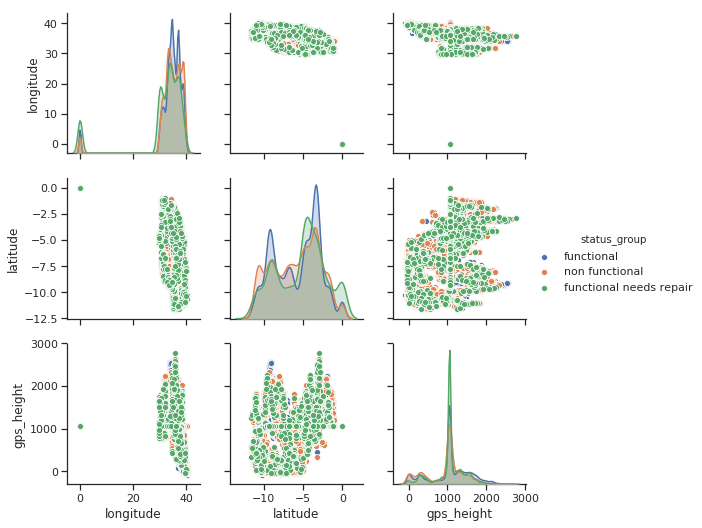

In [46]:
sns.set(style='ticks')
sns.pairplot(df_viz[['longitude', 'latitude', 'gps_height', 'status_group']],\
            hue='status_group', diag_kind='kde');


Splitting train_features set into train and test for model training and predictions

In [47]:
y = train_labels['status_group']
X_train_clean.shape, y.shape

((59400, 277), (59400,))

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_train_clean, y, test_size=0.25, random_state=42, shuffle=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((44550, 277), (14850, 277), (44550,), (14850,))

# First Try Decision Tree

In [49]:
model = tree.DecisionTreeClassifier()
%time model.fit(X=X_train, y=y_train)
model.feature_importances_ 
print(model.score(X=X_test, y=y_test)) # 1.0
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

CPU times: user 3.49 s, sys: 148 ms, total: 3.64 s
Wall time: 3.64 s
0.7416161616161616
0.7416161616161616
[[6350  547 1201]
 [ 499  380  195]
 [1171  224 4283]]
                         precision    recall  f1-score   support

             functional       0.79      0.78      0.79      8098
functional needs repair       0.33      0.35      0.34      1074
         non functional       0.75      0.75      0.75      5678

              micro avg       0.74      0.74      0.74     14850
              macro avg       0.63      0.63      0.63     14850
           weighted avg       0.74      0.74      0.74     14850



In [50]:
accuracy_score(y_test, y_pred)

0.7416161616161616

In [51]:
confusion_matrix(y_test, y_pred)

array([[6350,  547, 1201],
       [ 499,  380,  195],
       [1171,  224, 4283]])

In [52]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.79      0.78      0.79      8098
functional needs repair       0.33      0.35      0.34      1074
         non functional       0.75      0.75      0.75      5678

              micro avg       0.74      0.74      0.74     14850
              macro avg       0.63      0.63      0.63     14850
           weighted avg       0.74      0.74      0.74     14850



In [53]:
pipelineTree = make_pipeline(StandardScaler(), 
                        tree.DecisionTreeClassifier())

pipelineTree.fit(X_train, y_train)
y_pred = pipelineTree.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.7416835016835017
[[6352  549 1197]
 [ 488  379  207]
 [1174  221 4283]]
                         precision    recall  f1-score   support

             functional       0.79      0.78      0.79      8098
functional needs repair       0.33      0.35      0.34      1074
         non functional       0.75      0.75      0.75      5678

              micro avg       0.74      0.74      0.74     14850
              macro avg       0.63      0.63      0.63     14850
           weighted avg       0.74      0.74      0.74     14850



In [54]:
accuracy_score(y_test, y_pred)

0.7416835016835017

In [55]:
confusion_matrix(y_test, y_pred)

array([[6352,  549, 1197],
       [ 488,  379,  207],
       [1174,  221, 4283]])

In [56]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.79      0.78      0.79      8098
functional needs repair       0.33      0.35      0.34      1074
         non functional       0.75      0.75      0.75      5678

              micro avg       0.74      0.74      0.74     14850
              macro avg       0.63      0.63      0.63     14850
           weighted avg       0.74      0.74      0.74     14850



# Random Forest

In [57]:
model = RandomForestClassifier(n_estimators=200,min_samples_leaf=3 ,n_jobs=-1,max_features=0.25)
%time model.fit(X_train, y_train)
y_pred= model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

CPU times: user 1min 22s, sys: 252 ms, total: 1min 22s
Wall time: 1min 22s
0.808956228956229
[[7339  145  614]
 [ 600  325  149]
 [1254   75 4349]]
                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      8098
functional needs repair       0.60      0.30      0.40      1074
         non functional       0.85      0.77      0.81      5678

              micro avg       0.81      0.81      0.81     14850
              macro avg       0.75      0.66      0.69     14850
           weighted avg       0.80      0.81      0.80     14850



In [58]:
accuracy_score(y_test, y_pred)

0.808956228956229

In [59]:
confusion_matrix(y_test, y_pred)

array([[7339,  145,  614],
       [ 600,  325,  149],
       [1254,   75, 4349]])

In [60]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      8098
functional needs repair       0.60      0.30      0.40      1074
         non functional       0.85      0.77      0.81      5678

              micro avg       0.81      0.81      0.81     14850
              macro avg       0.75      0.66      0.69     14850
           weighted avg       0.80      0.81      0.80     14850



In [62]:
accuracy_score(y_test, y_pred)

confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
pipelineRandFor = make_pipeline(StandardScaler(), 
                        RandomForestClassifier(n_estimators=200,min_samples_leaf=3 ,n_jobs=-1,max_features=0.25))

pipelineRandFor.fit(X_train, y_train)
y_pred = pipelineRandFor.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      8098
functional needs repair       0.60      0.30      0.40      1074
         non functional       0.85      0.77      0.81      5678

              micro avg       0.81      0.81      0.81     14850
              macro avg       0.75      0.66      0.69     14850
           weighted avg       0.80      0.81      0.80     14850

0.8094276094276094
[[7342  141  615]
 [ 597  327  150]
 [1251   76 4351]]
                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      8098
functional needs repair       0.60      0.30      0.40      1074
         non functional       0.85      0.77      0.81      5678

              micro avg       0.81      0.81      0.81     14850
              macro avg       0.75      0.66      0.69     14850
           weighted avg       0.80      0.81      0.80     14850



In [63]:
accuracy_score(y_test, y_pred)

0.8094276094276094

In [64]:
confusion_matrix(y_test, y_pred)

array([[7342,  141,  615],
       [ 597,  327,  150],
       [1251,   76, 4351]])

In [65]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      8098
functional needs repair       0.60      0.30      0.40      1074
         non functional       0.85      0.77      0.81      5678

              micro avg       0.81      0.81      0.81     14850
              macro avg       0.75      0.66      0.69     14850
           weighted avg       0.80      0.81      0.80     14850



# Logistic Regresion

In [66]:
#let's see how our model does here
model = LogisticRegression()
%time model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

CPU times: user 13.8 s, sys: 216 ms, total: 14.1 s
Wall time: 14.1 s
0.7077441077441078
[[7435    0  663]
 [ 911    0  163]
 [2603    0 3075]]
                         precision    recall  f1-score   support

             functional       0.68      0.92      0.78      8098
functional needs repair       0.00      0.00      0.00      1074
         non functional       0.79      0.54      0.64      5678

              micro avg       0.71      0.71      0.71     14850
              macro avg       0.49      0.49      0.47     14850
           weighted avg       0.67      0.71      0.67     14850



In [67]:
accuracy_score(y_test, y_pred)

0.7077441077441078

In [68]:
confusion_matrix(y_test, y_pred)

array([[7435,    0,  663],
       [ 911,    0,  163],
       [2603,    0, 3075]])

In [69]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.68      0.92      0.78      8098
functional needs repair       0.00      0.00      0.00      1074
         non functional       0.79      0.54      0.64      5678

              micro avg       0.71      0.71      0.71     14850
              macro avg       0.49      0.49      0.47     14850
           weighted avg       0.67      0.71      0.67     14850



In [71]:
accuracy_score(y_test, y_pred)

confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
pipelineLR = make_pipeline(StandardScaler(), 
                        LogisticRegression())
pipelineLR.fit(X_train, y_train)
y_pred = pipelineLR.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.68      0.92      0.78      8098
functional needs repair       0.00      0.00      0.00      1074
         non functional       0.79      0.54      0.64      5678

              micro avg       0.71      0.71      0.71     14850
              macro avg       0.49      0.49      0.47     14850
           weighted avg       0.67      0.71      0.67     14850

0.7424242424242424
[[7258   50  790]
 [ 766   87  221]
 [1976   22 3680]]
                         precision    recall  f1-score   support

             functional       0.73      0.90      0.80      8098
functional needs repair       0.55      0.08      0.14      1074
         non functional       0.78      0.65      0.71      5678

              micro avg       0.74      0.74      0.74     14850
              macro avg       0.69      0.54      0.55     14850
           weighted avg       0.74      0.74      0.72     14850



In [72]:
accuracy_score(y_test, y_pred)

0.7424242424242424

In [73]:
confusion_matrix(y_test, y_pred)

array([[7258,   50,  790],
       [ 766,   87,  221],
       [1976,   22, 3680]])

In [74]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.73      0.90      0.80      8098
functional needs repair       0.55      0.08      0.14      1074
         non functional       0.78      0.65      0.71      5678

              micro avg       0.74      0.74      0.74     14850
              macro avg       0.69      0.54      0.55     14850
           weighted avg       0.74      0.74      0.72     14850



In [77]:
accuracy_score(y_test, y_pred)

confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
model = LogisticRegression(solver='newton-cg', multi_class='multinomial')
%time model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.73      0.90      0.80      8098
functional needs repair       0.55      0.08      0.14      1074
         non functional       0.78      0.65      0.71      5678

              micro avg       0.74      0.74      0.74     14850
              macro avg       0.69      0.54      0.55     14850
           weighted avg       0.74      0.74      0.72     14850

CPU times: user 11min 10s, sys: 6.13 s, total: 11min 16s
Wall time: 5min 11s
0.7423569023569023
[[7241   74  783]
 [ 755  119  200]
 [1979   35 3664]]
                         precision    recall  f1-score   support

             functional       0.73      0.89      0.80      8098
functional needs repair       0.52      0.11      0.18      1074
         non functional       0.79      0.65      0.71      5678

              micro avg       0.74      0.74      0.74     14850
              macro avg       0.68      0.55      0.56     14850

In [78]:
accuracy_score(y_test, y_pred)

0.7423569023569023

In [79]:
confusion_matrix(y_test, y_pred)

array([[7241,   74,  783],
       [ 755,  119,  200],
       [1979,   35, 3664]])

In [80]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.73      0.89      0.80      8098
functional needs repair       0.52      0.11      0.18      1074
         non functional       0.79      0.65      0.71      5678

              micro avg       0.74      0.74      0.74     14850
              macro avg       0.68      0.55      0.56     14850
           weighted avg       0.74      0.74      0.72     14850



In [84]:
accuracy_score(y_test, y_pred)

confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
pipelineLR2 = make_pipeline(StandardScaler(), 
                        LogisticRegression(solver='newton-cg', multi_class='multinomial'))

pipelineLR2.fit(X_train, y_train)
y_pred = pipelineLR2.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.73      0.89      0.80      8098
functional needs repair       0.52      0.11      0.18      1074
         non functional       0.79      0.65      0.71      5678

              micro avg       0.74      0.74      0.74     14850
              macro avg       0.68      0.55      0.56     14850
           weighted avg       0.74      0.74      0.72     14850

0.7445117845117845
[[7242   80  776]
 [ 742  125  207]
 [1949   40 3689]]
                         precision    recall  f1-score   support

             functional       0.73      0.89      0.80      8098
functional needs repair       0.51      0.12      0.19      1074
         non functional       0.79      0.65      0.71      5678

              micro avg       0.74      0.74      0.74     14850
              macro avg       0.68      0.55      0.57     14850
           weighted avg       0.74      0.74      0.72     14850



In [85]:
accuracy_score(y_test, y_pred)

0.7445117845117845

In [86]:
confusion_matrix(y_test, y_pred)

array([[7242,   80,  776],
       [ 742,  125,  207],
       [1949,   40, 3689]])

In [87]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.73      0.89      0.80      8098
functional needs repair       0.51      0.12      0.19      1074
         non functional       0.79      0.65      0.71      5678

              micro avg       0.74      0.74      0.74     14850
              macro avg       0.68      0.55      0.57     14850
           weighted avg       0.74      0.74      0.72     14850



# XGBoost

In [89]:
model = xgb.XGBClassifier(n_estimators=100, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.7652525252525253
[[7530   58  510]
 [ 747  174  153]
 [1978   40 3660]]
                         precision    recall  f1-score   support

             functional       0.73      0.93      0.82      8098
functional needs repair       0.64      0.16      0.26      1074
         non functional       0.85      0.64      0.73      5678

              micro avg       0.77      0.77      0.77     14850
              macro avg       0.74      0.58      0.60     14850
           weighted avg       0.77      0.77      0.75     14850



In [90]:
accuracy_score(y_test, y_pred)

0.7652525252525253

In [91]:
confusion_matrix(y_test, y_pred)

array([[7530,   58,  510],
       [ 747,  174,  153],
       [1978,   40, 3660]])

In [92]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.73      0.93      0.82      8098
functional needs repair       0.64      0.16      0.26      1074
         non functional       0.85      0.64      0.73      5678

              micro avg       0.77      0.77      0.77     14850
              macro avg       0.74      0.58      0.60     14850
           weighted avg       0.77      0.77      0.75     14850



In [93]:
pipelineXGB = make_pipeline(StandardScaler(), 
                        xgb.XGBClassifier(n_estimators=100, max_depth=5, base_score=0.5,
                            objective='binary:logistic', random_state=0))

pipelineLR2.fit(X_train, y_train)
y_pred = pipelineLR2.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.7445117845117845
[[7242   80  776]
 [ 742  125  207]
 [1949   40 3689]]
                         precision    recall  f1-score   support

             functional       0.73      0.89      0.80      8098
functional needs repair       0.51      0.12      0.19      1074
         non functional       0.79      0.65      0.71      5678

              micro avg       0.74      0.74      0.74     14850
              macro avg       0.68      0.55      0.57     14850
           weighted avg       0.74      0.74      0.72     14850



In [94]:
accuracy_score(y_test, y_pred)

0.7445117845117845

In [95]:
confusion_matrix(y_test, y_pred)

array([[7242,   80,  776],
       [ 742,  125,  207],
       [1949,   40, 3689]])

In [96]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.73      0.89      0.80      8098
functional needs repair       0.51      0.12      0.19      1074
         non functional       0.79      0.65      0.71      5678

              micro avg       0.74      0.74      0.74     14850
              macro avg       0.68      0.55      0.57     14850
           weighted avg       0.74      0.74      0.72     14850



# Cross validation

In [97]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(model, X_train_clean, y, cv=5))

[0.76761215 0.76752799 0.76792929 0.76893939 0.77395184]


In [98]:
modelRF = RandomForestClassifier(n_estimators=200,min_samples_leaf=3 ,n_jobs=-1,max_features=0.25)
%time modelRF.fit(X_train, y_train)
print(cross_val_score(modelRF, X_train_clean, y, cv=5))

CPU times: user 1min 21s, sys: 0 ns, total: 1min 21s
Wall time: 1min 21s
[0.8166821  0.81222119 0.81447811 0.80984848 0.80998485]
